In [2]:
!pip install opencv-python

  Using cached opencv_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)


In [8]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import pandas as pd
import xarray as xr
#import cv2 # EEH what is this used for?

In [9]:
# Load the pre-trained model
model = tf.keras.models.load_model('/home/jovyan/shared/jiarui-notebooks/efficientnet_2020_2023.keras')

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 101, 41, 1)]         0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 101, 41, 1)           0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 101, 41, 1)           3         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 103, 43, 1)           0         ['normalization[0][0]']   

In [10]:
input_shape = model.input_shape
print("Model input shape: ", input_shape)

Model input shape:  (None, 101, 41, 1)


In [11]:
import calendar
import os.path
from dateutil.relativedelta import relativedelta
# Specify your longitude and latitude range
lats = slice(25, 0)
lons = slice(70, 80)

# Initialize a list to store the data
data_list = []

# Iterate over the years and months
start_date = pd.to_datetime('2022-09-01')
end_date = pd.to_datetime('2022-9-30')

curr_date = start_date
while curr_date <= end_date:
    year = curr_date.year
    month = curr_date.month

    # Get the number of days in the month
    _, num_days = calendar.monthrange(year, month)

    # Construct the file path
    file_path = f'/home/jovyan/shared/data_sst/{year}{month:02d}_sea_surface_temperature.nc'

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f'File not found: {file_path}. Skipping this month.')
        curr_date += relativedelta(months=1)
        continue

    # Open the dataset
    ds = xr.open_dataset(file_path)

    # Select the time points
    time_points = pd.date_range(start=f'{year}-{month:02d}-01T09:00:00', end=f'{year}-{month:02d}-{num_days}T09:00:00', freq='D')
    ds_selected_time = ds.sel(time0=time_points, method='nearest')

    # Select the longitude and latitude
    ds_selected = ds_selected_time.sel(lon=lons, lat=lats)

    # Get the sea_surface_temperature values
    sst_data = ds_selected['sea_surface_temperature'].values
    sst_data = np.expand_dims(sst_data, axis=-1)

    # Append the data to the list
    data_list.append(sst_data)

    # Move to the next month
    curr_date += relativedelta(months=1)

    # Print a message
    print(f'Successfully processed data for: {year}-{month:02d}')

# Concatenate all the data
sst_data = np.concatenate(data_list, axis=0)

print(sst_data.shape)

Successfully processed data for: 2022-09
(30, 101, 41, 1)


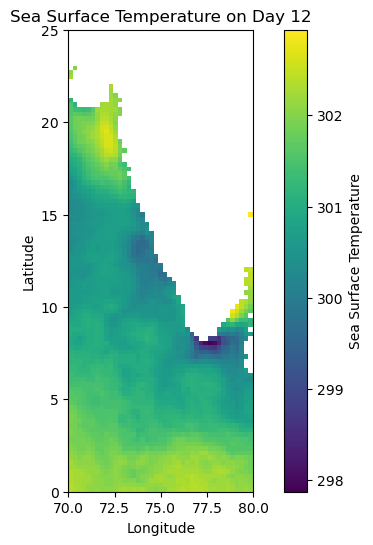

In [12]:
from matplotlib import pyplot as plt
# Choose one day of data
day_index = 12  # choose the day
day_data = sst_data[day_index]

# Remove the last dimension
day_data = np.squeeze(day_data)

# Flip the data along the first axis
day_data = np.flipud(day_data)

# Get the lat and lon values
lat_values = ds_selected.lat.values
lon_values = ds_selected.lon.values

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the data of the day
plt.imshow(day_data, cmap='viridis', origin='lower', extent=[lon_values.min(), lon_values.max(), lat_values.min(), lat_values.max()])

# Add a colorbar
plt.colorbar(label='Sea Surface Temperature')

# Set the labels for the x and y axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title
plt.title('Sea Surface Temperature on Day {}'.format(day_index))

# Show the plot
plt.show()

In [13]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
from dateutil.relativedelta import relativedelta

def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2020-09-01', '2020-09-30')


Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202009_sst_diff.nc...
(30,)


In [14]:
labels

2020-09-01    0
2020-09-02    0
2020-09-03    0
2020-09-04    0
2020-09-05    0
2020-09-06    0
2020-09-07    0
2020-09-08    0
2020-09-09    0
2020-09-10    0
2020-09-11    0
2020-09-12    0
2020-09-13    0
2020-09-14    0
2020-09-15    0
2020-09-16    0
2020-09-17    0
2020-09-18    0
2020-09-19    0
2020-09-20    0
2020-09-21    0
2020-09-22    0
2020-09-23    0
2020-09-24    0
2020-09-25    0
2020-09-26    0
2020-09-27    0
2020-09-28    0
2020-09-29    0
2020-09-30    0
dtype: int64

In [16]:
processed_data_list = []

for day_data in sst_data:
    day_data = np.squeeze(day_data)

    day_data = np.flipud(day_data)

    sst_data2 = np.nanmean(day_data)

    sst_data3 = day_data - sst_data2

    processed_data_list.append(sst_data3)

processed_data = np.array(processed_data_list)

In [17]:
processed_data

array([[[1.0737305 , 1.1362305 , 1.1362305 , ..., 0.57373047,
         0.57373047, 0.51123047],
        [1.1362305 , 1.1987305 , 1.1987305 , ..., 0.57373047,
         0.51123047, 0.51123047],
        [1.2612305 , 1.2612305 , 1.2612305 , ..., 0.51123047,
         0.44873047, 0.44873047],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[1.0359192 , 1.0984192 , 1.0359192 , ..., 0.5359192 ,
         0.5359192 , 0.5359192 ],
        [1.0984192 , 1.0984192 , 1.0984192 , ..., 0.4734192 ,
         0.4734192 , 0.4734192 ],
        [1.0984192 , 1.0984192 , 1.0984192 , ..., 0.3484192 ,
         0.3484192 , 0.3484192 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [   

In [18]:
for curr_index in range(len(processed_data)):
    day_data = processed_data[curr_index]  # Get the data from processed_data
    day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
    day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel
    prediction = model.predict(day_data)
    print(prediction)

1/1 [==============================] - 1s 1s/step
[[0.99999255]]
1/1 [==============================] - 0s 26ms/step
[[0.99999726]]
1/1 [==============================] - 0s 26ms/step
[[0.99999344]]
1/1 [==============================] - 0s 26ms/step
[[0.9999446]]
1/1 [==============================] - 0s 26ms/step
[[2.4239256e-07]]
1/1 [==============================] - 0s 25ms/step
[[3.44414e-07]]
1/1 [==============================] - 0s 46ms/step
[[3.9438558e-07]]
1/1 [==============================] - 0s 25ms/step
[[2.6789724e-08]]
1/1 [==============================] - 0s 26ms/step
[[2.4838627e-07]]
1/1 [==============================] - 0s 26ms/step
[[2.1469303e-07]]
1/1 [==============================] - 0s 25ms/step
[[1.338351e-07]]
1/1 [==============================] - 0s 26ms/step
[[5.194275e-07]]
1/1 [==============================] - 0s 25ms/step
[[2.1661485e-06]]
1/1 [==============================] - 0s 25ms/step
[[1.5913118e-06]]
1/1 [==============================] - 

In [19]:
ds = xr.open_dataset('/home/jovyan/shared/data_sst/202305_sea_surface_temperature.nc')
ds

<xarray.Dataset>
Dimensions:                  (lon: 1440, lat: 721, time0: 744)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                    (time0) datetime64[ns] 2023-05-01 ... 2023-05-31...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        ERA5 forecasts

In [20]:
labels

2020-09-01    0
2020-09-02    0
2020-09-03    0
2020-09-04    0
2020-09-05    0
2020-09-06    0
2020-09-07    0
2020-09-08    0
2020-09-09    0
2020-09-10    0
2020-09-11    0
2020-09-12    0
2020-09-13    0
2020-09-14    0
2020-09-15    0
2020-09-16    0
2020-09-17    0
2020-09-18    0
2020-09-19    0
2020-09-20    0
2020-09-21    0
2020-09-22    0
2020-09-23    0
2020-09-24    0
2020-09-25    0
2020-09-26    0
2020-09-27    0
2020-09-28    0
2020-09-29    0
2020-09-30    0
dtype: int64

In [21]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2022-08-01', '2022-08-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/202208_sst_diff.nc...
(31,)


In [22]:
labels

2022-08-01    0
2022-08-02    0
2022-08-03    0
2022-08-04    0
2022-08-05    0
2022-08-06    0
2022-08-07    0
2022-08-08    0
2022-08-09    1
2022-08-10    0
2022-08-11    1
2022-08-12    1
2022-08-13    0
2022-08-14    1
2022-08-15    0
2022-08-16    1
2022-08-17    1
2022-08-18    1
2022-08-19    1
2022-08-20    1
2022-08-21    1
2022-08-22    1
2022-08-23    1
2022-08-24    1
2022-08-25    1
2022-08-26    1
2022-08-27    1
2022-08-28    1
2022-08-29    1
2022-08-30    1
2022-08-31    1
dtype: int64